In [ ]:
from datasets import load_dataset
import pandas as pd


In [3]:
import os
import glob
import pandas as pd
from datasets import load_dataset

# assumes data has been downloaded locally
local_dir = "./data"
parquet_pattern = os.path.join(local_dir, "train-*-of-*.parquet")
shard_paths = sorted(glob.glob(parquet_pattern))

if not shard_paths:
    raise RuntimeError(f"No parquet files found at pattern {parquet_pattern}")

# loads local data
ds_stream = load_dataset(
    "parquet",
    data_files={"games": shard_paths},
    split="games",
    streaming=True
)


# function to filter games based on defined constraints
#TODO i should probably filter out players that have played less than X total games
def keep_game(example) -> bool:
    # 1) move_text contains 'eval'
    if "eval" not in example["movetext"]:
        return False

    # 2) num_moves >= 4
    if "4. " not in example.get("movetext"):
        return False

    # 3) time_control == '600+0'
    if example.get("TimeControl", "") != "600+0":
        return False

    return True



max_matches = 50000
filtered_rows = []

# Iterate over games and append matching games to array
for game in ds_stream:
    if keep_game(game):
        filtered_rows.append(game)
        if len(filtered_rows) >= max_matches:
            break

# Convert filtered games to pandas.DataFrame
df_filtered = pd.DataFrame(filtered_rows)
print(f"Collected {len(df_filtered)} games (up to {max_matches}).")
print(df_filtered.head(50))


Collected 232177 games (up to 500000).
                                                Event  \
0      Rapid swiss https://lichess.org/swiss/2V3L9Zwn   
1      Rapid swiss https://lichess.org/swiss/T9vocdaQ   
2      Rapid swiss https://lichess.org/swiss/T9vocdaQ   
3      Rapid swiss https://lichess.org/swiss/7siKNYGN   
4      Rapid swiss https://lichess.org/swiss/7siKNYGN   
5      Rapid swiss https://lichess.org/swiss/7siKNYGN   
6      Rapid swiss https://lichess.org/swiss/7siKNYGN   
7      Rapid swiss https://lichess.org/swiss/iQC7K9kp   
8      Rapid swiss https://lichess.org/swiss/iQC7K9kp   
9      Rapid swiss https://lichess.org/swiss/iQC7K9kp   
10     Rapid swiss https://lichess.org/swiss/iQC7K9kp   
11     Rapid swiss https://lichess.org/swiss/iQC7K9kp   
12     Rapid swiss https://lichess.org/swiss/s48lWjcR   
13     Rapid swiss https://lichess.org/swiss/Z6Cmixc1   
14                                   Rated Rapid game   
15                                   Rated Rapid 

In [4]:
df_filtered.to_csv("../data/filtered_df_checkpoint.csv", index=False)

In [12]:
import pandas as pd
import re


#Compute Elo distribution (mean and median) for White and Black
white_elos = df_filtered['WhiteElo']
black_elos = df_filtered['BlackElo']

elo_stats = pd.DataFrame({
    'Color': ['White', 'Black'],
    'Mean_Elo': [white_elos.mean(), black_elos.mean()],
    'Median_Elo': [white_elos.median(), black_elos.median()],
    'Max_Elo': [white_elos.max(), black_elos.max()],
    'Min_Elo': [white_elos.min(), black_elos.min()],
    'STD_Elo': [white_elos.std(), black_elos.std()],
})
print("=== Elo Statistics ===")
print(elo_stats)


def count_full_moves(move_text: str) -> int:
    # Find all move‐number prefixes like "1. ", "2. ", etc.
    numbers = re.findall(r'\b(\d+)\.\s', move_text)
    if not numbers:
        return 0
    return max(map(int, numbers))

# Apply to every row
df_filtered['parsed_num_moves'] = df_filtered['movetext'].apply(count_full_moves)

# statistics for game length
move_length_stats = df_filtered['parsed_num_moves'].describe()
print("\n=== Game‐Length Statistics (in full‐move counts) ===")
print(move_length_stats)


=== Elo Statistics ===
   Color     Mean_Elo  Median_Elo  Max_Elo  Min_Elo     STD_Elo
0  White  1536.356004      1533.0     3119      400  390.929736
1  Black  1536.518777      1537.0     3095      400  390.987127

=== Game‐Length Statistics (in full‐move counts) ===
count    232177.000000
mean         33.281458
std          14.889076
min           4.000000
25%          23.000000
50%          30.000000
75%          41.000000
max         227.000000
Name: parsed_num_moves, dtype: float64


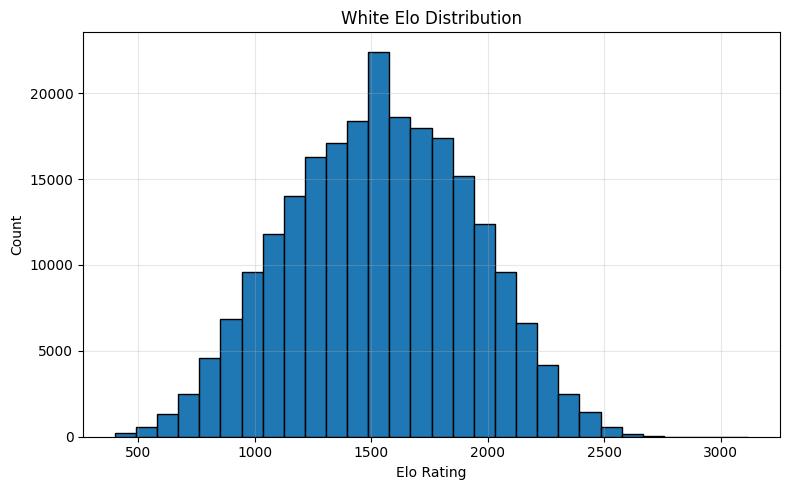

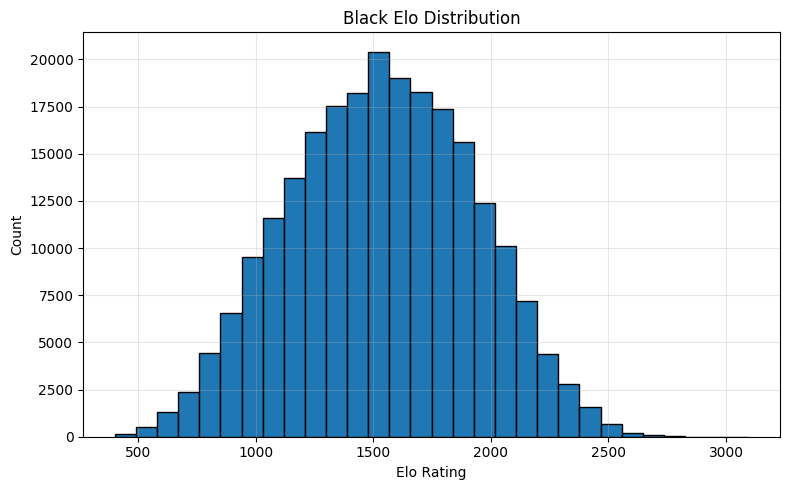

In [6]:
import matplotlib.pyplot as plt

# Extract Elo ratings
white_elos = df_filtered["WhiteElo"]
black_elos = df_filtered["BlackElo"]

#  White Elo Distribution
plt.figure(figsize=(8, 5))
plt.hist(white_elos, bins=30, edgecolor="black")
plt.title("White Elo Distribution")
plt.xlabel("Elo Rating")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Black Elo Distribution
plt.figure(figsize=(8, 5))
plt.hist(black_elos, bins=30, edgecolor="black")
plt.title("Black Elo Distribution")
plt.xlabel("Elo Rating")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import re

def parse_moves_and_evals_with_delta(move_text: str) -> pd.DataFrame:
    """
    Parse a Lichess move_text string and extract every move (both White and Black)
    along with its evaluation and the change in evaluation from the previous ply.
    Returns a DataFrame with columns:
      - move_number (int)
      - color ('white' or 'black')
      - move (str, SAN)
      - eval (float or str for mate scores)
      - delta_eval (float, difference from previous eval; NaN for first ply)
    """

    # Patterns for capturing White and Black moves with their evaluations
    white_pattern = re.compile(r'\b(\d+)\.\s*([^\s\{]+)\s*\{\s*\[%eval\s*([^\]\s]+)')
    black_pattern = re.compile(r'\b(\d+)\.\.\.\s*([^\s\{]+)\s*\{\s*\[%eval\s*([^\]\s]+)')

    records = []

    # Extract all White moves
    for w_match in white_pattern.finditer(move_text):
        move_num = int(w_match.group(1))
        move_san = w_match.group(2)
        eval_str = w_match.group(3)
        try:
            eval_val = float(eval_str)
        except ValueError:
            if "-" in eval_str:
                eval_val = -1000
            else:
               eval_val = 1000
        records.append({
            'move_number': move_num,
            'color': 'white',
            'move': move_san,
            'eval': eval_val
        })

    # Extract all Black moves
    for b_match in black_pattern.finditer(move_text):
        move_num = int(b_match.group(1))
        move_san = b_match.group(2)
        eval_str = b_match.group(3)
        try:
            eval_val = float(eval_str)
        except ValueError:
            if "-" in eval_str:
               eval_val = -1000
            else:
               eval_val = 1000
        records.append({
            'move_number': move_num,
            'color': 'black',
            'move': move_san,
            'eval': eval_val
        })

    # Build and sort DataFrame: ensure White before Black
    df_moves = pd.DataFrame(records)
    df_moves['sort_key'] = df_moves['move_number'] * 2 + df_moves['color'].map({'white': 0, 'black': 1})
    df_moves = df_moves.sort_values('sort_key').drop(columns='sort_key').reset_index(drop=True)

    # Compute delta_eval: difference between current eval and previous ply eval
    df_moves['delta_eval'] = df_moves['eval'].diff()
    df_moves.loc[df_moves.index[0], 'delta_eval'] = 0.0

    return df_moves

df_filtered['moves_evals'] = df_filtered['movetext'].apply(parse_moves_and_evals_with_delta)
# View the first game’s parsed moves, evals, and deltas
print(df_filtered.loc[0, 'moves_evals'])


    move_number  color    move     eval  delta_eval
0             1  white      e4     0.18        0.00
1             1  black      e5     0.21        0.03
2             2  white     Nf3     0.13       -0.08
3             2  black      d6     0.48        0.35
4             3  white     Bc4     0.25       -0.23
5             3  black     f6?     1.34        1.09
6             4  white      d3     0.97       -0.37
7             4  black      c5     1.35        0.38
8             5  white     Be3     0.97       -0.38
9             5  black    b6??     5.48        4.51
10            6  white   O-O??     1.84       -3.64
11            6  black   Be7??     5.42        3.58
12            7  white    Nc3?     2.68       -2.74
13            7  black   Nh6??     6.27        3.59
14            8  white   Nd5??     3.20       -3.07
15            8  black    Bf8?     5.42        2.22
16            9  white    Nc3?     4.31       -1.11
17            9  black     b5?     5.96        1.65
18          

In [8]:
#df_filtered.to_csv("../data/filtered_df_with_move_evals.csv", index=False)

In [7]:
#df_filtered = pd.read_csv("../data/filtered_df_with_move_evals.csv")

In [14]:
import numpy as np

def _diffs_list(evals_cp, pov_color, mate_threshold=900):
    sign = 1 if pov_color == 'white' else -1
    diffs = []
    for s1, s2 in zip(evals_cp[0::2], evals_cp[1::2]):
        if s1 is None or s2 is None:
            continue
        # skip “mate” as it skews data to much
        # TODO include missed mate as feature
        if abs(s1) >= mate_threshold or abs(s2) >= mate_threshold:
            continue
        d = (s2 - s1) * sign
        diffs.append(max(0, d))
    return diffs


def _accuracy_cp(evals_cp, pov_color):
    diffs = _diffs_list(evals_cp, pov_color)
    if not diffs:
        return None
    return int(round(np.mean(diffs)))

def compute_accuracy_cp_from_moves_evals(moves_evals):
    """
    Given moves_evals as a list of dicts:
      [{'move_number':1,'color':'white','move':'e4','eval':0.18,'delta_eval':0.00}, … ]
    returns a tuple (white_accuracy_cp, black_accuracy_cp).
    """
    # turn into DataFrame
    g = pd.DataFrame(moves_evals)
    # sort by move_number, with white before black
    g['color_ord'] = (g['color'] == 'black').astype(int)
    g = g.sort_values(['move_number','color_ord'])
    # convert eval (in pawns) → centipawns ints, None if missing
    evals_cp = [
        int(round(v * 100)) if pd.notna(v) else None
        for v in g['eval']
    ]
    w_acc = _accuracy_cp(evals_cp, 'white')
    b_acc = _accuracy_cp(evals_cp, 'black')
    return pd.Series({
        'white_accuracy_cp': w_acc,
        'black_accuracy_cp': b_acc
    })

df_filtered[['white_accuracy_cp', 'black_accuracy_cp']] = (
    df_filtered['moves_evals']
      .apply(compute_accuracy_cp_from_moves_evals)
)

# Inspect
print(df_filtered[['white_accuracy_cp','black_accuracy_cp']])


        white_accuracy_cp  black_accuracy_cp
0                     140                  0
1                      85                  0
2                     222                 11
3                     103                  1
4                      89                  3
...                   ...                ...
232172                 89                  3
232173                101                  2
232174                 86                  3
232175                 75                  3
232176                 16                  6

[232177 rows x 2 columns]


In [15]:
import re
import pandas as pd
import chess
import chess.pgn


def clean_san(san: str) -> str:
    """
    Strip move annotations (?, !, +, #) from SAN so python‐chess can parse it.
    """
    return re.sub(r"[?!+#]+$", "", san)


def count_pawn_structure(board: chess.Board, color: bool):
    """
    Count isolated, doubled, and tripled pawns for the given color on 'board'.
    Returns a tuple (isolated_count, doubled_count, tripled_count).
    """
    pawns = list(board.pieces(chess.PAWN, color))
    files = {}
    for sq in pawns:
        f = chess.square_file(sq)
        files.setdefault(f, 0)
        files[f] += 1

    isolated = 0
    doubled = 0
    tripled = 0
    for f, cnt in files.items():
        if cnt == 1:
            # No neighbor pawn on f–1 or f+1
            if (f - 1 not in files) and (f + 1 not in files):
                isolated += 1
        if cnt == 2:
            doubled += 1
        if cnt >= 3:
            tripled += 1
    return isolated, doubled, tripled


def count_center_control(board: chess.Board, color: bool):
    """
    Count how many minor pieces (knights or bishops) of 'color'
    attack or defend any of the four center squares {d4,d5,e4,e5}
    in the given board position.
    """
    center_squares = [chess.D4, chess.D5, chess.E4, chess.E5]
    total = 0
    for sq in center_squares:
        # attackers of sq by 'color'
        for attacker in board.attackers(color, sq):
            p = board.piece_at(attacker)
            if p.piece_type in (chess.KNIGHT, chess.BISHOP):
                total += 1
        # defenders are just attackers of sq by the opposite color
        for defender in board.attackers(not color, sq):
            p = board.piece_at(defender)
            if p.piece_type in (chess.KNIGHT, chess.BISHOP):
                total += 1
    return total


def extract_game_features(moves_df: pd.DataFrame) -> dict:
    """
    Given a DataFrame 'moves_df' with columns:
        ["move_number", "color", "move", "eval", "delta_eval"],
    compute features for White and Black, returning a nested dict.

    Replaces any None values with 0 so downstream regressors see only numeric entries.
    """
    # 1) Determine total full moves
    san_list = []
    for _, row in moves_df.iterrows():
        san = clean_san(row["move"])
        san_list.append(san)
    total_half_moves = len(san_list)
    total_full_moves = (total_half_moves + 1) // 2

    def half_idx_for_frac(f: float) -> int:
        fm = int(f * total_full_moves)
        hi = fm * 2
        return min(hi, total_half_moves)

    quartile_indices = {
        "25": half_idx_for_frac(0.25),
        "50": half_idx_for_frac(0.50),
        "75": half_idx_for_frac(0.75),
        "100": total_half_moves
    }

    # Initialize board and trackers
    board = chess.Board()
    castle_done = {"white": False, "black": False}
    moves_before_castle = {"white": total_full_moves, "black": total_full_moves}

    development_times = {
        "white": {"knights": [], "bishops": [], "rq": []},
        "black": {"knights": [], "bishops": [], "rq": []}
    }

    pawn_counts = {
        "white": {q: (0, 0, 0) for q in quartile_indices},
        "black": {q: (0, 0, 0) for q in quartile_indices}
    }

    legal_diff = {q: 0 for q in quartile_indices}

    center_control = {"white": 0, "black": 0}

    initial_map = {
        sq: (board.piece_at(sq).color, board.piece_at(sq).piece_type, sq)
        for sq in board.piece_map()
    }
    current_to_initial = {sq: info for sq, info in initial_map.items()}
    moved_pieces_after10 = {"white": set(), "black": set()}

    blunder_moves = {"white": [], "black": []}
    mistake_moves = {"white": [], "black": []}

    win_op = {"white": None, "black": None}
    opp_win_op = {"white": None, "black": None}

    knight_edge_first = {"white": None, "black": None}
    knight_edge_count = {"white": 0, "black": 0}
    rook_7th_first = {"white": None, "black": None}

    # Iterate through half-moves
    for i, row in moves_df.iterrows():
        half_idx = i + 1
        color = row["color"]
        move_no = row["move_number"]
        san = clean_san(row["move"])
        d_eval = row["delta_eval"]
        e = row["eval"]

        # Count blunders and mistakes
        if color == "white":
            if d_eval is not None and d_eval < -2.0:
                blunder_moves["white"].append(move_no)
            if d_eval is not None and d_eval < -0.5:
                mistake_moves["white"].append(move_no)
            if win_op["white"] is None and e is not None and e >= 3.0:
                win_op["white"] = move_no
            if opp_win_op["white"] is None and e is not None and e <= -3.0:
                opp_win_op["white"] = move_no
        else:
            if d_eval is not None and d_eval > 2.0:
                blunder_moves["black"].append(move_no)
            if d_eval is not None and d_eval > 0.5:
                mistake_moves["black"].append(move_no)
            if win_op["black"] is None and e is not None and e <= -3.0:
                win_op["black"] = move_no
            if opp_win_op["black"] is None and e is not None and e >= 3.0:
                opp_win_op["black"] = move_no

        # parse san
        try:
            mv = board.parse_san(san)
        except Exception:
            san2 = re.sub(r"[?!+#]+$", "", row["move"])
            mv = board.parse_san(san2)

        # Moves before castling
        if not castle_done[color] and san.startswith("O-O"):
            castle_done[color] = True
            moves_before_castle[color] = move_no

        # Development
        piece = board.piece_at(mv.from_square)
        if piece:
            cstr = "white" if piece.color == chess.WHITE else "black"
            ptype = piece.piece_type
            if ptype == chess.KNIGHT:
                development_times[cstr]["knights"].append(move_no)
            if ptype == chess.BISHOP:
                development_times[cstr]["bishops"].append(move_no)
            if ptype in (chess.ROOK, chess.QUEEN):
                development_times[cstr]["rq"].append(move_no)

        # Knight on edge & rook to 7th
        if piece and piece.piece_type == chess.KNIGHT:
            to_file = chess.square_file(mv.to_square)
            if to_file in (0, 7):
                if knight_edge_first[color] is None:
                    knight_edge_first[color] = move_no
                knight_edge_count[color] += 1

        if piece and piece.piece_type == chess.ROOK:
            to_rank = chess.square_rank(mv.to_square)
            if color == "white" and to_rank == 6 and rook_7th_first["white"] is None:
                rook_7th_first["white"] = move_no
            if color == "black" and to_rank == 1 and rook_7th_first["black"] is None:
                rook_7th_first["black"] = move_no

        # Unique pieces moved after 10 full moves
        if piece:
            info = current_to_initial.get(mv.from_square)
            if info:
                cstr = "white" if piece.color == chess.WHITE else "black"
                moved_pieces_after10[cstr].add(info[2])

        board.push(mv)

        # Pawn structure & legal-move diff at quartiles
        for label, idx in quartile_indices.items():
            if half_idx == idx:
                w_iso, w_dbl, w_tri = count_pawn_structure(board, chess.WHITE)
                b_iso, b_dbl, b_tri = count_pawn_structure(board, chess.BLACK)
                pawn_counts["white"][label] = (w_iso, w_dbl, w_tri)
                pawn_counts["black"][label] = (b_iso, b_dbl, b_tri)

                turn_saved = board.turn
                board.turn = chess.WHITE
                w_moves = board.legal_moves.count()
                board.turn = chess.BLACK
                b_moves = board.legal_moves.count()
                board.turn = turn_saved
                legal_diff[label] = w_moves - b_moves

    # Development before queen/rooks
    dev_before = {"white": 0, "black": 0}
    for color in ("white", "black"):
        knights = development_times[color]["knights"]
        bishops = development_times[color]["bishops"]
        rq = development_times[color]["rq"]
        if knights and bishops and rq:
            if max(knights) < min(rq) and max(bishops) < min(rq):
                dev_before[color] = 1

    # Center control after 5 full moves (half-move idx = 10)
    board5 = chess.Board()
    for i, row in moves_df.iterrows():
        if i == 10:
            break
        san = clean_san(row["move"])
        mv = board5.parse_san(san)
        board5.push(mv)
    center_control["white"] = count_center_control(board5, chess.WHITE)
    center_control["black"] = count_center_control(board5, chess.BLACK)

    # Unique pieces moved after 10 full moves (half-move idx = 20)
    board10 = chess.Board()
    moved_after10 = {"white": set(), "black": set()}
    for i, row in moves_df.iterrows():
        san = clean_san(row["move"])
        mv = board10.parse_san(san)
        piece = board10.piece_at(mv.from_square)
        if piece:
            cstr = "white" if piece.color == chess.WHITE else "black"
            info = {sq: info for sq, info in current_to_initial.items() if info[0] == piece.color}
            initial_sq = None
            for sq, inf in info.items():
                if inf[1] == piece.piece_type and sq == mv.from_square:
                    initial_sq = inf[2]
                    break
            if initial_sq:
                moved_after10[cstr].add(initial_sq)
        board10.push(mv)
        if i == 19:
            break

    unique_after10 = {
        "white": len(moved_after10["white"]),
        "black": len(moved_after10["black"])
    }

    # First blunder/mistake and counts
    first_blunder = {
        "white": blunder_moves["white"][0] if blunder_moves["white"] else None,
        "black": blunder_moves["black"][0] if blunder_moves["black"] else None
    }
    blunder_counts = {
        "white": len(blunder_moves["white"]),
        "black": len(blunder_moves["black"])
    }
    first_mistake = {
        "white": mistake_moves["white"][0] if mistake_moves["white"] else None,
        "black": mistake_moves["black"][0] if mistake_moves["black"] else None
    }
    mistake_counts = {
        "white": len(mistake_moves["white"]),
        "black": len(mistake_moves["black"])
    }

    # Moves before castling for colors that never castled
    for c in ("white", "black"):
        if not castle_done[c]:
            moves_before_castle[c] = total_full_moves

    # Replace all None with 0 in these nested dicts
    for d in (first_blunder, first_mistake, win_op, opp_win_op, knight_edge_first, rook_7th_first):
        for color in ("white", "black"):
            if d[color] is None:
                d[color] = 0

    # Gather everything into a single dict
    features = {
        "total_full_moves": total_full_moves,
        "moves_before_castle": moves_before_castle,
        "pawn_counts_at": pawn_counts,               # nested by color → quartile → (iso,dbl,tri)
        "legal_move_diff_at": legal_diff,            # by quartile → (White legal − Black legal)
        "development_before": dev_before,            # 1 or 0
        "center_control_after_5": center_control,    # minor‐piece control counts
        "unique_pieces_after_10": unique_after10,    # count of distinct initial squares moved
        "blunder_counts": blunder_counts,            # total # of blunders
        "first_blunder_move": first_blunder,         # full‐move index
        "mistake_counts": mistake_counts,            # total # of mistakes
        "first_mistake_move": first_mistake,         # full‐move index
        "first_win_opportunity": win_op,             # full‐move for win opportunity
        "first_opp_win_opportunity": opp_win_op,     # full‐move for opponent win opp
        "knight_edge_first": knight_edge_first,      # full‐move of first knight on edge
        "knight_edge_count": knight_edge_count,      # total times knight moved to edge
        "rook_7th_first": rook_7th_first             # full‐move of first rook→7th/2nd
    }

    return features

# apply feature extraction to all games
features_list = df_filtered["moves_evals"].apply(extract_game_features)

features_df = pd.DataFrame(features_list.tolist())

import pprint
pprint.pprint(features_df)


        total_full_moves         moves_before_castle  \
0                     30   {'white': 6, 'black': 30}   
1                     35  {'white': 14, 'black': 35}   
2                     20  {'white': 20, 'black': 20}   
3                     40  {'white': 14, 'black': 40}   
4                     32  {'white': 13, 'black': 32}   
...                  ...                         ...   
232172                28  {'white': 10, 'black': 28}   
232173                18  {'white': 18, 'black': 14}   
232174                35  {'white': 35, 'black': 17}   
232175                27  {'white': 27, 'black': 27}   
232176                39  {'white': 39, 'black': 39}   

                                           pawn_counts_at  \
0       {'white': {'25': (0, 0, 0), '50': (0, 0, 0), '...   
1       {'white': {'25': (0, 0, 0), '50': (0, 0, 0), '...   
2       {'white': {'25': (0, 0, 0), '50': (1, 1, 0), '...   
3       {'white': {'25': (0, 0, 0), '50': (0, 0, 0), '...   
4       {'white': {'25

In [10]:
#features_df.to_csv("../data/features.csv", index=False)

In [ ]:
#features_df = pd.read_csv("../data/features.csv")

In [16]:
# flatten one level of nesting (white/black):
raw = pd.json_normalize(features_list)

# This creates columns like “moves_before_castle.white” and “moves_before_castle.black”,
# as well as “pawn_counts_at.25.white” etc.

# ── 3) Rename columns to look like “moves_before_castle_white”:
raw.columns = [col.replace(".", "_") for col in raw.columns]

# ── 4) Some columns (like pawn_counts_at_25_white) contain 3‑tuples (iso, dbl, tri).
# We detect those columns whose values are tuples and split each tuple into three new columns.

# Find columns with tuple values:
tuple_cols = [
    c for c in raw.columns
    if raw[c].apply(lambda x: isinstance(x, tuple)).any()
]

for col in tuple_cols:
    # Create three new columns from the tuple (iso, dbl, tri)
    raw[[f"{col}_iso", f"{col}_dbl", f"{col}_tri"]] = pd.DataFrame(
        raw[col].tolist(), index=raw.index
    )
    # Drop the original “tuple” column
    raw.drop(columns=[col], inplace=True)

# “raw” is now fully flattened. Every white/black metric is two separate columns,
# and any triple‑tuple fields (pawn_counts, doubled, tripled) have been unpacked.

raw["ECO"] = df_filtered["ECO"]
raw["Termination"] = df_filtered["Termination"]

#divide df into 10 equally sized bins based on whites elo
raw['elo_bin'] = pd.qcut(df_filtered['WhiteElo'], q=10, labels=False)
raw['white_acpl'] = df_filtered['white_accuracy_cp']
raw['black_acpl'] = df_filtered['black_accuracy_cp']

# check created bins
binned, bin_edges = pd.qcut(df_filtered['WhiteElo'], q=10, labels=False, retbins=True)

print("Bin edges (WhiteElo):")
print(bin_edges)
print(raw.columns)

Bin edges (WhiteElo):
[ 400. 1015. 1186. 1317. 1438. 1533. 1645. 1761. 1886. 2047. 3119.]
Index(['total_full_moves', 'moves_before_castle_white',
       'moves_before_castle_black', 'legal_move_diff_at_25',
       'legal_move_diff_at_50', 'legal_move_diff_at_75',
       'legal_move_diff_at_100', 'development_before_white',
       'development_before_black', 'center_control_after_5_white',
       'center_control_after_5_black', 'unique_pieces_after_10_white',
       'unique_pieces_after_10_black', 'blunder_counts_white',
       'blunder_counts_black', 'first_blunder_move_white',
       'first_blunder_move_black', 'mistake_counts_white',
       'mistake_counts_black', 'first_mistake_move_white',
       'first_mistake_move_black', 'first_win_opportunity_white',
       'first_win_opportunity_black', 'first_opp_win_opportunity_white',
       'first_opp_win_opportunity_black', 'knight_edge_first_white',
       'knight_edge_first_black', 'knight_edge_count_white',
       'knight_edge_count_bl

In [ ]:
#raw.to_csv("../data/final_data.csv", index=False)

In [ ]:
#raw = pd.read_csv("../data/final_data.csv")

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Numeric transformer: StandardScaler()
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

# Categorical transformer: OneHotEncoder
categorical_transformer = Pipeline(
    steps=[
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)

num_cols = [
    'total_full_moves',
    'moves_before_castle_white',
    'moves_before_castle_black',
    'legal_move_diff_at_25',
    'legal_move_diff_at_50',
    'legal_move_diff_at_75',
    'legal_move_diff_at_100',
    'development_before_white',
    'development_before_black',
    'center_control_after_5_white',
    'center_control_after_5_black',
    'unique_pieces_after_10_white',
    'unique_pieces_after_10_black',
    'blunder_counts_white',
    'blunder_counts_black',
    'first_blunder_move_white',
    'first_blunder_move_black',
    'mistake_counts_white',
    'mistake_counts_black',
    'first_mistake_move_white',
    'first_mistake_move_black',
    'first_win_opportunity_white',
    'first_win_opportunity_black',
    'first_opp_win_opportunity_white',
    'first_opp_win_opportunity_black',
    'knight_edge_first_white',
    'knight_edge_first_black',
    'knight_edge_count_white',
    'knight_edge_count_black',
    'rook_7th_first_white',
    'rook_7th_first_black',
    'pawn_counts_at_white_25_iso',
    'pawn_counts_at_white_25_dbl',
    'pawn_counts_at_white_25_tri',
    'pawn_counts_at_white_50_iso',
    'pawn_counts_at_white_50_dbl',
    'pawn_counts_at_white_50_tri',
    'pawn_counts_at_white_75_iso',
    'pawn_counts_at_white_75_dbl',
    'pawn_counts_at_white_75_tri',
    'pawn_counts_at_white_100_iso',
    'pawn_counts_at_white_100_dbl',
    'pawn_counts_at_white_100_tri',
    'pawn_counts_at_black_25_iso',
    'pawn_counts_at_black_25_dbl',
    'pawn_counts_at_black_25_tri',
    'pawn_counts_at_black_50_iso',
    'pawn_counts_at_black_50_dbl',
    'pawn_counts_at_black_50_tri',
    'pawn_counts_at_black_75_iso',
    'pawn_counts_at_black_75_dbl',
    'pawn_counts_at_black_75_tri',
    'pawn_counts_at_black_100_iso',
    'pawn_counts_at_black_100_dbl',
    'pawn_counts_at_black_100_tri',
    'black_acpl',
    'white_acpl'
]
cat_cols = ["ECO", "Termination"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",  # drop any other columns
)


In [28]:
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Hyperparameter OOptimization using Optuna
# Goal is to find the best set oh HP's for our classification task
# Ran with a subset (30k) of games due to computational limitations


num_cols = [
    'total_full_moves',
    'moves_before_castle_white',
    'moves_before_castle_black',
    'legal_move_diff_at_25',
    'legal_move_diff_at_50',
    'legal_move_diff_at_75',
    'legal_move_diff_at_100',
    'development_before_white',
    'development_before_black',
    'center_control_after_5_white',
    'center_control_after_5_black',
    'unique_pieces_after_10_white',
    'unique_pieces_after_10_black',
    'blunder_counts_white',
    'blunder_counts_black',
    'first_blunder_move_white',
    'first_blunder_move_black',
    'mistake_counts_white',
    'mistake_counts_black',
    'first_mistake_move_white',
    'first_mistake_move_black',
    'first_win_opportunity_white',
     'first_win_opportunity_black',
    'first_opp_win_opportunity_white',
    'first_opp_win_opportunity_black',
    'knight_edge_first_white',
    'knight_edge_first_black',
    'knight_edge_count_white',
    'knight_edge_count_black',
    'rook_7th_first_white',
    'rook_7th_first_black',
    'pawn_counts_at_white_25_iso',
    'pawn_counts_at_white_25_dbl',
    'pawn_counts_at_white_25_tri',
    'pawn_counts_at_white_50_iso',
    'pawn_counts_at_white_50_dbl',
    'pawn_counts_at_white_50_tri',
    'pawn_counts_at_white_75_iso',
    'pawn_counts_at_white_75_dbl',
    'pawn_counts_at_white_75_tri',
    'pawn_counts_at_white_100_iso',
    'pawn_counts_at_white_100_dbl',
    'pawn_counts_at_white_100_tri',
    'pawn_counts_at_black_25_iso',
    'pawn_counts_at_black_25_dbl',
    'pawn_counts_at_black_25_tri',
    'pawn_counts_at_black_50_iso',
    'pawn_counts_at_black_50_dbl',
    'pawn_counts_at_black_50_tri',
    'pawn_counts_at_black_75_iso',
    'pawn_counts_at_black_75_dbl',
    'pawn_counts_at_black_75_tri',
    'pawn_counts_at_black_100_iso',
    'pawn_counts_at_black_100_dbl',
    'pawn_counts_at_black_100_tri',
    'black_acpl',
    'white_acpl'
]
cat_cols = ['ECO', 'Termination']

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Use stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# X and y
X = raw[:1000]
y = raw['elo_bin'].astype(int)[:1000]

# Define Optuna objective function
def objective(trial):
    # Sample hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 200, 1500)
    max_depth = trial.suggest_int("max_depth", 10, 100)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Create pipeline
    clf = Pipeline([
        ("pre", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=True,
            random_state=42,
            n_jobs=1
        ))
    ])

    # Evaluate with CV
    score = cross_val_score(clf, X, y, cv=cv, scoring="accuracy", n_jobs=1)
    return score.mean()

# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=True)

# Print best params
print("Best parameters:")
print(study.best_params)
print(f"Best CV accuracy: {study.best_value:.4f}")


[I 2025-06-08 18:23:31,161] A new study created in memory with name: no-name-22aa4c81-b38e-4a56-8f84-309b412f09b1
Best trial: 0. Best value: 0.212:   2%|▏         | 1/50 [00:06<05:07,  6.29s/it]

[I 2025-06-08 18:23:37,447] Trial 0 finished with value: 0.21200000000000002 and parameters: {'n_estimators': 1494, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.21200000000000002.


Best trial: 1. Best value: 0.215:   4%|▍         | 2/50 [00:07<02:39,  3.32s/it]

[I 2025-06-08 18:23:38,687] Trial 1 finished with value: 0.215 and parameters: {'n_estimators': 229, 'max_depth': 51, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.215.


Best trial: 1. Best value: 0.215:   6%|▌         | 3/50 [00:35<11:26, 14.60s/it]

[I 2025-06-08 18:24:06,713] Trial 2 finished with value: 0.21300000000000002 and parameters: {'n_estimators': 780, 'max_depth': 79, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.215.


Best trial: 1. Best value: 0.215:   8%|▊         | 4/50 [01:06<16:14, 21.19s/it]

[I 2025-06-08 18:24:37,998] Trial 3 finished with value: 0.205 and parameters: {'n_estimators': 740, 'max_depth': 48, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.215.


Best trial: 1. Best value: 0.215:  10%|█         | 5/50 [01:30<16:32, 22.06s/it]

[I 2025-06-08 18:25:01,618] Trial 4 finished with value: 0.20800000000000002 and parameters: {'n_estimators': 819, 'max_depth': 89, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 1 with value: 0.215.


Best trial: 5. Best value: 0.23:  12%|█▏        | 6/50 [01:32<11:16, 15.38s/it] 

[I 2025-06-08 18:25:04,024] Trial 5 finished with value: 0.22999999999999998 and parameters: {'n_estimators': 474, 'max_depth': 42, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.22999999999999998.


Best trial: 5. Best value: 0.23:  14%|█▍        | 7/50 [01:38<08:51, 12.36s/it]

[I 2025-06-08 18:25:10,159] Trial 6 finished with value: 0.20900000000000002 and parameters: {'n_estimators': 843, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 5 with value: 0.22999999999999998.


Best trial: 5. Best value: 0.23:  16%|█▌        | 8/50 [01:40<06:10,  8.82s/it]

[I 2025-06-08 18:25:11,403] Trial 7 finished with value: 0.21800000000000003 and parameters: {'n_estimators': 288, 'max_depth': 99, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 5 with value: 0.22999999999999998.


Best trial: 5. Best value: 0.23:  18%|█▊        | 9/50 [02:02<08:55, 13.06s/it]

[I 2025-06-08 18:25:33,791] Trial 8 finished with value: 0.21600000000000003 and parameters: {'n_estimators': 564, 'max_depth': 76, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 5 with value: 0.22999999999999998.


Best trial: 5. Best value: 0.23:  20%|██        | 10/50 [02:14<08:23, 12.59s/it]

[I 2025-06-08 18:25:45,339] Trial 9 finished with value: 0.21100000000000002 and parameters: {'n_estimators': 1467, 'max_depth': 59, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.22999999999999998.


Best trial: 5. Best value: 0.23:  22%|██▏       | 11/50 [02:20<06:51, 10.54s/it]

[I 2025-06-08 18:25:51,224] Trial 10 finished with value: 0.22200000000000003 and parameters: {'n_estimators': 1234, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.22999999999999998.


Best trial: 5. Best value: 0.23:  24%|██▍       | 12/50 [02:25<05:41,  9.00s/it]

[I 2025-06-08 18:25:56,693] Trial 11 finished with value: 0.22800000000000004 and parameters: {'n_estimators': 1156, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.22999999999999998.


Best trial: 5. Best value: 0.23:  26%|██▌       | 13/50 [02:30<04:51,  7.87s/it]

[I 2025-06-08 18:26:01,982] Trial 12 finished with value: 0.225 and parameters: {'n_estimators': 1116, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 5 with value: 0.22999999999999998.


Best trial: 13. Best value: 0.231:  28%|██▊       | 14/50 [02:36<04:17,  7.16s/it]

[I 2025-06-08 18:26:07,490] Trial 13 finished with value: 0.231 and parameters: {'n_estimators': 1097, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.231.


Best trial: 13. Best value: 0.231:  30%|███       | 15/50 [02:38<03:21,  5.77s/it]

[I 2025-06-08 18:26:10,032] Trial 14 finished with value: 0.22399999999999998 and parameters: {'n_estimators': 480, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 13 with value: 0.231.


Best trial: 15. Best value: 0.232:  32%|███▏      | 16/50 [02:43<03:08,  5.55s/it]

[I 2025-06-08 18:26:15,081] Trial 15 finished with value: 0.23199999999999998 and parameters: {'n_estimators': 1004, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  34%|███▍      | 17/50 [02:49<02:59,  5.43s/it]

[I 2025-06-08 18:26:20,221] Trial 16 finished with value: 0.23199999999999998 and parameters: {'n_estimators': 1022, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  36%|███▌      | 18/50 [02:54<02:52,  5.39s/it]

[I 2025-06-08 18:26:25,530] Trial 17 finished with value: 0.223 and parameters: {'n_estimators': 972, 'max_depth': 26, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  38%|███▊      | 19/50 [03:00<02:56,  5.68s/it]

[I 2025-06-08 18:26:31,883] Trial 18 finished with value: 0.22799999999999998 and parameters: {'n_estimators': 1300, 'max_depth': 65, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  40%|████      | 20/50 [03:04<02:32,  5.09s/it]

[I 2025-06-08 18:26:35,595] Trial 19 finished with value: 0.215 and parameters: {'n_estimators': 975, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  42%|████▏     | 21/50 [03:09<02:25,  5.01s/it]

[I 2025-06-08 18:26:40,432] Trial 20 finished with value: 0.22599999999999998 and parameters: {'n_estimators': 990, 'max_depth': 33, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  44%|████▍     | 22/50 [03:14<02:24,  5.17s/it]

[I 2025-06-08 18:26:45,962] Trial 21 finished with value: 0.231 and parameters: {'n_estimators': 1099, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  46%|████▌     | 23/50 [03:21<02:34,  5.74s/it]

[I 2025-06-08 18:26:53,021] Trial 22 finished with value: 0.22999999999999998 and parameters: {'n_estimators': 1352, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  48%|████▊     | 24/50 [03:26<02:23,  5.53s/it]

[I 2025-06-08 18:26:58,069] Trial 23 finished with value: 0.229 and parameters: {'n_estimators': 1033, 'max_depth': 33, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  50%|█████     | 25/50 [03:30<02:01,  4.85s/it]

[I 2025-06-08 18:27:01,349] Trial 24 finished with value: 0.22599999999999998 and parameters: {'n_estimators': 649, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  52%|█████▏    | 26/50 [03:35<01:57,  4.90s/it]

[I 2025-06-08 18:27:06,353] Trial 25 finished with value: 0.231 and parameters: {'n_estimators': 911, 'max_depth': 45, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  54%|█████▍    | 27/50 [03:41<02:02,  5.34s/it]

[I 2025-06-08 18:27:12,709] Trial 26 finished with value: 0.23199999999999998 and parameters: {'n_estimators': 1217, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  56%|█████▌    | 28/50 [03:48<02:05,  5.69s/it]

[I 2025-06-08 18:27:19,214] Trial 27 finished with value: 0.229 and parameters: {'n_estimators': 1246, 'max_depth': 33, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  58%|█████▊    | 29/50 [03:53<01:57,  5.59s/it]

[I 2025-06-08 18:27:24,586] Trial 28 finished with value: 0.21399999999999997 and parameters: {'n_estimators': 1366, 'max_depth': 56, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  60%|██████    | 30/50 [04:25<04:33, 13.67s/it]

[I 2025-06-08 18:27:57,089] Trial 29 finished with value: 0.211 and parameters: {'n_estimators': 1194, 'max_depth': 36, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  62%|██████▏   | 31/50 [04:31<03:32, 11.18s/it]

[I 2025-06-08 18:28:02,457] Trial 30 finished with value: 0.209 and parameters: {'n_estimators': 1467, 'max_depth': 63, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  64%|██████▍   | 32/50 [04:36<02:50,  9.45s/it]

[I 2025-06-08 18:28:07,864] Trial 31 finished with value: 0.231 and parameters: {'n_estimators': 1078, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  66%|██████▌   | 33/50 [04:41<02:16,  8.03s/it]

[I 2025-06-08 18:28:12,582] Trial 32 finished with value: 0.22999999999999998 and parameters: {'n_estimators': 901, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  68%|██████▊   | 34/50 [04:47<01:56,  7.31s/it]

[I 2025-06-08 18:28:18,216] Trial 33 finished with value: 0.22999999999999998 and parameters: {'n_estimators': 1156, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  70%|███████   | 35/50 [04:53<01:43,  6.91s/it]

[I 2025-06-08 18:28:24,178] Trial 34 finished with value: 0.22999999999999998 and parameters: {'n_estimators': 1035, 'max_depth': 50, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  72%|███████▏  | 36/50 [05:14<02:37, 11.27s/it]

[I 2025-06-08 18:28:45,638] Trial 35 finished with value: 0.21000000000000002 and parameters: {'n_estimators': 742, 'max_depth': 40, 'min_samples_split': 9, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  74%|███████▍  | 37/50 [05:19<02:01,  9.37s/it]

[I 2025-06-08 18:28:50,581] Trial 36 finished with value: 0.22800000000000004 and parameters: {'n_estimators': 904, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  76%|███████▌  | 38/50 [05:26<01:43,  8.59s/it]

[I 2025-06-08 18:28:57,359] Trial 37 finished with value: 0.231 and parameters: {'n_estimators': 1350, 'max_depth': 44, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  78%|███████▊  | 39/50 [06:05<03:14, 17.70s/it]

[I 2025-06-08 18:29:36,302] Trial 38 finished with value: 0.217 and parameters: {'n_estimators': 1275, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  80%|████████  | 40/50 [06:09<02:16, 13.63s/it]

[I 2025-06-08 18:29:40,429] Trial 39 finished with value: 0.22399999999999998 and parameters: {'n_estimators': 818, 'max_depth': 37, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  82%|████████▏ | 41/50 [06:12<01:35, 10.64s/it]

[I 2025-06-08 18:29:44,095] Trial 40 finished with value: 0.21999999999999997 and parameters: {'n_estimators': 1039, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 15. Best value: 0.232:  84%|████████▍ | 42/50 [06:18<01:13,  9.13s/it]

[I 2025-06-08 18:29:49,715] Trial 41 finished with value: 0.231 and parameters: {'n_estimators': 1107, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 15 with value: 0.23199999999999998.


Best trial: 42. Best value: 0.234:  86%|████████▌ | 43/50 [06:24<00:57,  8.16s/it]

[I 2025-06-08 18:29:55,592] Trial 42 finished with value: 0.23399999999999999 and parameters: {'n_estimators': 1166, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 42 with value: 0.23399999999999999.


Best trial: 42. Best value: 0.234:  88%|████████▊ | 44/50 [06:30<00:45,  7.57s/it]

[I 2025-06-08 18:30:01,809] Trial 43 finished with value: 0.229 and parameters: {'n_estimators': 1191, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 42 with value: 0.23399999999999999.


Best trial: 42. Best value: 0.234:  90%|█████████ | 45/50 [06:36<00:34,  7.00s/it]

[I 2025-06-08 18:30:07,466] Trial 44 finished with value: 0.223 and parameters: {'n_estimators': 1194, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 42 with value: 0.23399999999999999.


Best trial: 42. Best value: 0.234:  92%|█████████▏| 46/50 [06:43<00:27,  6.95s/it]

[I 2025-06-08 18:30:14,309] Trial 45 finished with value: 0.23199999999999998 and parameters: {'n_estimators': 1403, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 42 with value: 0.23399999999999999.


Best trial: 42. Best value: 0.234:  94%|█████████▍| 47/50 [06:49<00:20,  6.89s/it]

[I 2025-06-08 18:30:21,069] Trial 46 finished with value: 0.22000000000000003 and parameters: {'n_estimators': 1409, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 42 with value: 0.23399999999999999.


Best trial: 42. Best value: 0.234:  96%|█████████▌| 48/50 [07:23<00:30, 15.01s/it]

[I 2025-06-08 18:30:55,027] Trial 47 finished with value: 0.21600000000000003 and parameters: {'n_estimators': 1307, 'max_depth': 35, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 42 with value: 0.23399999999999999.


Best trial: 42. Best value: 0.234:  98%|█████████▊| 49/50 [07:31<00:12, 12.68s/it]

[I 2025-06-08 18:31:02,260] Trial 48 finished with value: 0.231 and parameters: {'n_estimators': 1487, 'max_depth': 81, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 42 with value: 0.23399999999999999.


Best trial: 42. Best value: 0.234: 100%|██████████| 50/50 [07:33<00:00,  9.06s/it]

[I 2025-06-08 18:31:04,263] Trial 49 finished with value: 0.211 and parameters: {'n_estimators': 260, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 42 with value: 0.23399999999999999.
Best parameters:
{'n_estimators': 1166, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt'}
Best CV accuracy: 0.2340


Bins [0] vs [9] → accuracy: 0.898
Bins [0, 1] vs [8, 9] → accuracy: 0.839
Bins [0, 1, 2] vs [7, 8, 9] → accuracy: 0.790
Bins [0, 1, 2, 3] vs [6, 7, 8, 9] → accuracy: 0.746
Bins [0, 1, 2, 3, 4] vs [5, 6, 7, 8, 9] → accuracy: 0.711


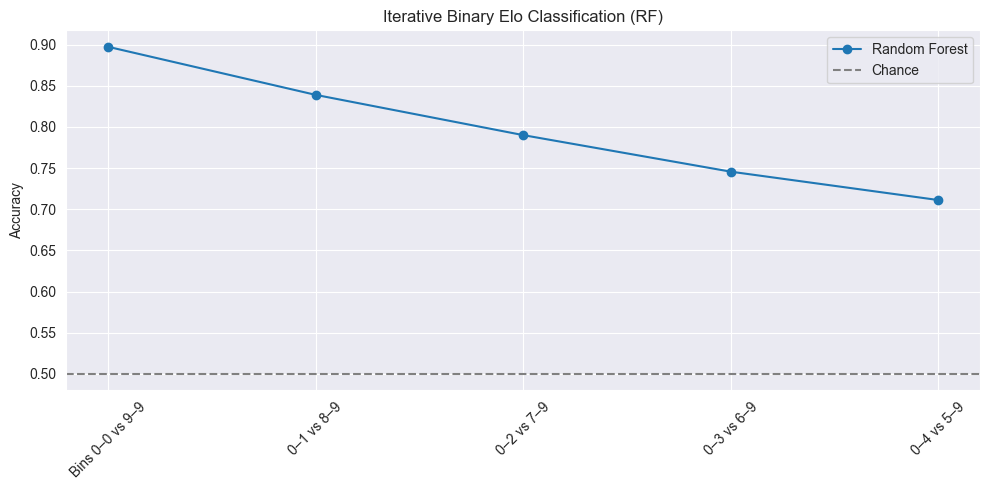

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


num_cols = [
    'total_full_moves',
    'moves_before_castle_white',
    'moves_before_castle_black',
    'legal_move_diff_at_25',
    'legal_move_diff_at_50',
    'legal_move_diff_at_75',
    'legal_move_diff_at_100',
    'development_before_white',
    'development_before_black',
    'center_control_after_5_white',
    'center_control_after_5_black',
    'unique_pieces_after_10_white',
    'unique_pieces_after_10_black',
    'blunder_counts_white',
    'blunder_counts_black',
    'first_blunder_move_white',
    'first_blunder_move_black',
    'mistake_counts_white',
    'mistake_counts_black',
    'first_mistake_move_white',
    'first_mistake_move_black',
    'first_win_opportunity_white',
     'first_win_opportunity_black',
    'first_opp_win_opportunity_white',
    'first_opp_win_opportunity_black',
    'knight_edge_first_white',
    'knight_edge_first_black',
    'knight_edge_count_white',
    'knight_edge_count_black',
    'rook_7th_first_white',
    'rook_7th_first_black',
    'pawn_counts_at_white_25_iso',
    'pawn_counts_at_white_25_dbl',
    'pawn_counts_at_white_25_tri',
    'pawn_counts_at_white_50_iso',
    'pawn_counts_at_white_50_dbl',
    'pawn_counts_at_white_50_tri',
    'pawn_counts_at_white_75_iso',
    'pawn_counts_at_white_75_dbl',
    'pawn_counts_at_white_75_tri',
    'pawn_counts_at_white_100_iso',
    'pawn_counts_at_white_100_dbl',
    'pawn_counts_at_white_100_tri',
    'pawn_counts_at_black_25_iso',
    'pawn_counts_at_black_25_dbl',
    'pawn_counts_at_black_25_tri',
    'pawn_counts_at_black_50_iso',
    'pawn_counts_at_black_50_dbl',
    'pawn_counts_at_black_50_tri',
    'pawn_counts_at_black_75_iso',
    'pawn_counts_at_black_75_dbl',
    'pawn_counts_at_black_75_tri',
    'pawn_counts_at_black_100_iso',
    'pawn_counts_at_black_100_dbl',
    'pawn_counts_at_black_100_tri',
    'black_acpl',
    'white_acpl'
]
cat_cols = ['ECO', 'Termination']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# best hp's determined by hyperparameter optimization ran on 1000 games
#{'n_estimators': 1166, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt'}
rf_pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(bootstrap = True, max_depth = 16, min_samples_leaf=8, min_samples_split=6, n_estimators = 1166, max_features='sqrt')),

])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


def run_iterative_bin_classification(df, elo_bin_col='elo_bin', max_k=4, n_per_bin=15000):
    accuracies = []

    for k in range(max_k + 1):  # k = 0 → 4
        left_bins = list(range(0, k + 1))          # e.g. [0], [0,1], ...
        right_bins = list(range(9 - k, 10))        # e.g. [9], [8,9], ...

        df_left = df[df[elo_bin_col].isin(left_bins)]
        df_right = df[df[elo_bin_col].isin(right_bins)]

        n = min(len(df_left), len(df_right), n_per_bin)

        df_A = df_left.sample(n=n, random_state=42).copy()
        df_B = df_right.sample(n=n, random_state=42).copy()

        df_A['binary_class'] = 0
        df_B['binary_class'] = 1

        df_bin = pd.concat([df_A, df_B], axis=0).sample(frac=1, random_state=42)

        X = df_bin[num_cols + cat_cols]
        y = df_bin['binary_class']

        acc = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
        print(f"Bins {left_bins} vs {right_bins} → accuracy: {acc:.3f}")

        accuracies.append((left_bins, right_bins, acc))

    return accuracies


accuracies = run_iterative_bin_classification(raw, elo_bin_col='elo_bin', max_k=4, n_per_bin=8000)

x_labels = ["Bins 0–0 vs 9–9", "0–1 vs 8–9", "0–2 vs 7–9", "0–3 vs 6–9", "0–4 vs 5–9"]
y_vals = [acc for _, _, acc in accuracies]

plt.figure(figsize=(10, 5))
plt.plot(x_labels, y_vals, marker='o', label='Random Forest')
plt.axhline(0.5, color='gray', linestyle='--', label='Chance')
plt.ylabel("Accuracy")
plt.title("Iterative Binary Elo Classification (RF)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X = raw[num_cols + cat_cols]
y = raw['elo_bin']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#{'n_estimators': 1166, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 8, 'max_features': 'sqrt'}
clf_pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(bootstrap = True, max_depth = 16, min_samples_leaf=8, min_samples_split=6, n_estimators = 1166, max_features='sqrt')),
])
clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

Accuracy: 0.20985873029546043
              precision    recall  f1-score   support

           0      0.281     0.687     0.399      4664
           1      0.151     0.137     0.144      4642
           2      0.134     0.098     0.113      4643
           3      0.147     0.059     0.085      4649
           4      0.122     0.066     0.086      4654
           5      0.133     0.071     0.093      4635
           6      0.137     0.065     0.088      4623
           7      0.154     0.099     0.120      4650
           8      0.155     0.118     0.134      4654
           9      0.273     0.697     0.392      4622

    accuracy                          0.210     46436
   macro avg      0.169     0.210     0.165     46436
weighted avg      0.169     0.210     0.165     46436



In [21]:
rf = clf_pipeline.named_steps['clf']
importances = rf.feature_importances_
print(pd.Series(importances).sort_values(ascending=False).head(20))


10     0.145261
5      0.093314
6      0.089630
0      0.077822
1      0.066781
3      0.066622
8      0.066541
7      0.064389
2      0.064228
4      0.059644
9      0.043740
214    0.010163
463    0.006386
465    0.006338
244    0.006115
289    0.005021
11     0.003706
238    0.003593
241    0.003438
235    0.003332
dtype: float64


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

#runtime on 10 shards (230k games): interrupted after 1.5h
# TODO re-run

svm_pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", LinearSVC(random_state=42))
])

svm_pipeline.fit(X_train, y_train)

y_pred = svm_pipeline.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

debug_model = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, solver='saga'))
])
debug_model.fit(X_train, y_train)
print("Accuracy:", debug_model.score(X_test, y_test))


In [34]:
import pandas as pd
y_pred = y_pred.astype(int)

print("Ground truth class distribution:")
print(pd.Series(y_test).value_counts().sort_index())

print("\nPredicted class distribution:")
print(pd.Series(y_pred).value_counts().sort_index())


Ground truth class distribution:
elo_bin
0    4664
1    4642
2    4643
3    4649
4    4654
5    4635
6    4623
7    4650
8    4654
9    4622
Name: count, dtype: int64

Predicted class distribution:
0        5
1       11
2      344
3     6412
4    33158
5     6384
6      113
7        8
8        1
Name: count, dtype: int64


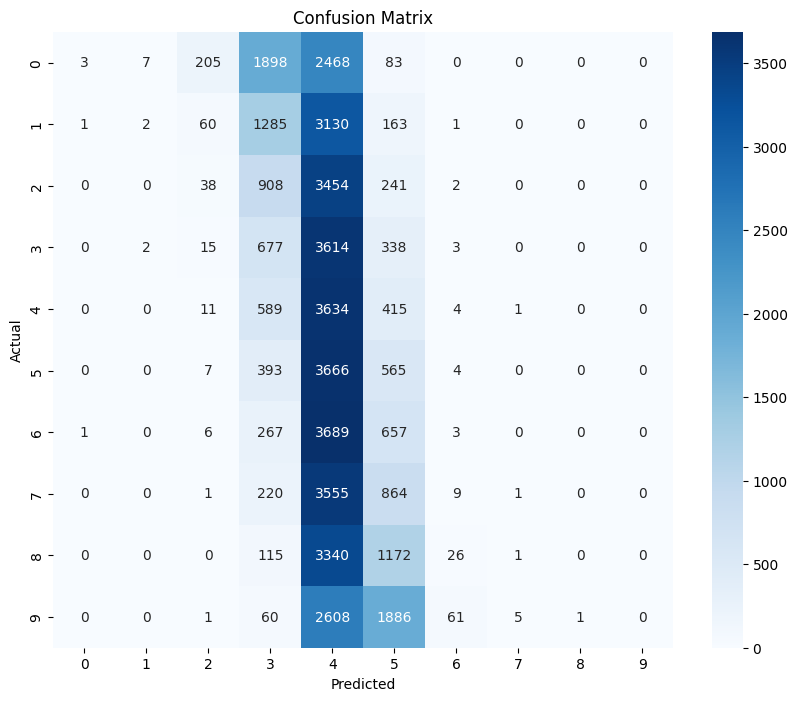

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [36]:
gt_counts = pd.Series(y_test).value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()
diff = pred_counts - gt_counts

print("\nClass prediction bias (predicted - actual):")
print(diff.sort_values())



Class prediction bias (predicted - actual):
0    -4659.0
8    -4653.0
7    -4642.0
1    -4631.0
6    -4510.0
2    -4299.0
5     1749.0
3     1763.0
4    28504.0
9        NaN
Name: count, dtype: float64


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

prec, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=sorted(y.unique()))

per_class_df = pd.DataFrame({
    'precision': prec,
    'recall': recall,
    'f1': f1,
    'support': support
}, index=sorted(y.unique()))

print("\nPer-class metrics:")
print(per_class_df)


In [24]:
import numpy as np

y_true = y_test.values
y_pred = clf_pipeline.predict(X_test)

# absolute difference between predicted and true bin
diff = np.abs(y_pred - y_true)

within_one = np.mean(diff <= 1)
print(f"Within‑1‑bin accuracy: {within_one:.3f}")

Within‑1‑bin accuracy: 0.455
